# MNIST handwritten digit recognition

In [1]:
import torch, torchvision
from torch import nn, optim
from torchvision import transforms, datasets

torch.manual_seed(1)

## Step 1: Load datasets

In [2]:
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

dataset = datasets.MNIST('./trainset', download = True, train = True,  transform = transform)
testset = datasets.MNIST('./testset',  download = True, train = False, transform = transform)
trainset, valset, _ = torch.utils.data.random_split(dataset, [30000, 10000, 20000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
valloader   = torch.utils.data.DataLoader(valset,   batch_size = BATCH_SIZE, shuffle = True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size = BATCH_SIZE, shuffle = True)

Let's take a closer look at the data...

In [3]:
dataiter = iter(testloader)
images, image_labels = dataiter.next()

print('Data dimensions (batch size x color channels x width x height):')
print(images.size(), '\n')
print('Label dimensions (batch size):')
print(image_labels.size(), '\n')
print('Total number of training samples:')
print(len(trainset), '\n')
print('Total number of validation samples:')
print(len(valset), '\n')
print('Total number of test samples:')
print(len(testset))

Data dimensions (batch size x color channels x width x height):
torch.Size([64, 1, 28, 28]) 

Label dimensions (batch size):
torch.Size([64]) 

Total number of training samples:
30000 

Total number of validation samples:
10000 

Total number of test samples:
10000


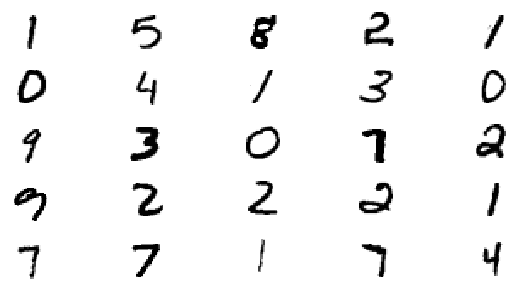

In [67]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize = (10, 5))
for i in range(25) :
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap = 'gray_r')

## Step 2: Declare model architecture

Our first network model will be a simple Multilayer Perceptron:

![Network image](https://miro.medium.com/max/700/1*HWhBextdDSkxYvz0kEMTVg.png)

In [5]:
INPUT_SIZE   = 784
HIDDEN1_SIZE = 128
HIDDEN2_SIZE = 64
OUTPUT_SIZE  = 10

# Input size matches unrolled image
assert INPUT_SIZE == images.size(1) * images.size(2) * images.size(3)

class Net(nn.Module) :
    
    def __init__(self) :
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN1_SIZE),
            nn.ReLU()
        )
        self.hidden1_layer = nn.Sequential(
            nn.Linear(HIDDEN1_SIZE, HIDDEN2_SIZE),
            nn.ReLU()
        )
        self.hidden2_layer = nn.Sequential(
            nn.Linear(HIDDEN2_SIZE, OUTPUT_SIZE),
            nn.LogSoftmax(dim = 1)
        )
    
    def forward(self, x) :
        x = self.input_layer(x)
        x = self.hidden1_layer(x)
        x = self.hidden2_layer(x)
        return x

model = Net()
print(model)

Net(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
  )
  (hidden1_layer): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (hidden2_layer): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


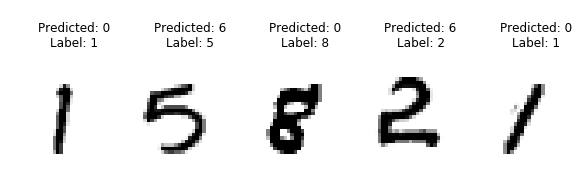

In [6]:
N_IMAGES = 5

# Let network predict digits
data      = images[:N_IMAGES].view(N_IMAGES, -1)
output    = model(data)
predicted = output.argmax(dim = 1)
label     = image_labels[:N_IMAGES]

# Display images and predictions
figure = plt.figure(figsize = (10, 5))
for i in range(N_IMAGES) :
    plt.subplot(1, N_IMAGES, i + 1)
    plt.axis('off')
    plt.title(f"""
        Predicted: {predicted[i]}
        Label: {label[i]}
    """)
    plt.imshow(images[i].numpy().squeeze(), cmap = 'gray_r')

As the weights are initialized randomly, the model's predictions are still far off.

Lets fix that by defining our training routine.

## Step 3: Train the model

In [7]:
LEARNING_RATE = 3e-3
MOMENTUM      = 9e-1

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM)

def train_step(data, labels, train = True) :
    model.train(train)
    
    # Forward pass
    data   = data.view(data.size(0), -1)
    output = model(data)
    loss   = criterion(output, labels)
    
    # Backpropagate loss through the network
    if train :
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Return loss and accuracy
    loss      = loss.detach() * data.size(0)
    predicted = output.argmax(dim = 1)
    accuracy  = (predicted == labels).sum()
    return loss.item(), accuracy.item()

Actually training our network takes a lot of time depending on the hardware, so let's go with 15 epochs.

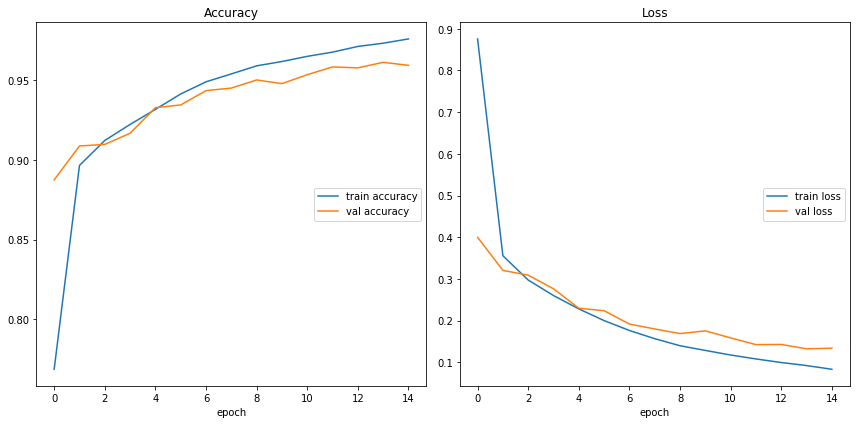

In [8]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from tqdm import tqdm

# Setup loss and accuracy plots
lossplot = PlotLosses(groups = {
    'Loss':     ['train loss',     'val loss'],
    'Accuracy': ['train accuracy', 'val accuracy']
}, outputs = [
    MatplotlibPlot(cell_size = (6, 3))
])

EPOCHS = 15

for epoch in range(EPOCHS) :
    logs = {}
    
    # Split epoch into training and validation phase
    for phase, train, loader in [
        ('train', True,  trainloader),
        ('val',   False, valloader)
    ] :
        running_loss = 0
        running_acc  = 0
        N_SAMPLES    = len(loader.dataset)

        # Train and/or accumulate loss
        for data, labels in tqdm(loader) :
            loss, acc = train_step(data, labels, train = train)
            running_loss += loss
            running_acc  += acc

        loss = running_loss / N_SAMPLES
        acc  = running_acc  / N_SAMPLES
        logs[phase + ' loss']     = loss
        logs[phase + ' accuracy'] = acc
    
    # Plot epoch loss
    lossplot.update(logs)
    lossplot.send()

Our model reaches an acceptable degree of accuracy on the training samples.

But to properly evaluate the network, we have to test its performance on yet unseen data.

## Step 4: Evaluate the model

In [11]:
running_loss = 0
running_acc  = 0
N_SAMPLES    = len(testloader.dataset)

for data, labels in testloader :
    loss, acc = train_step(data, labels, train = False)
    running_loss += loss
    running_acc  += acc

loss = running_loss / N_SAMPLES
acc  = running_acc  / N_SAMPLES
print(f'Evaluation result - Loss: {loss:.3f}, Accuracy: {acc:.3f}')

Evaluation result - Loss: 0.116, Accuracy: 0.963


The achieved accuracy is very close to the human score on the MNIST dataset, which is around 98%. \[[source](http://yann.lecun.com/exdb/publis/pdf/lecun-95a.pdf)\]

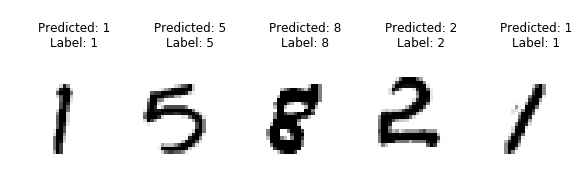

In [10]:
N_IMAGES = 5

# Let network predict digits
data      = images[:N_IMAGES].view(N_IMAGES, -1)
output    = model(data)
predicted = output.argmax(dim = 1)
label     = image_labels[:N_IMAGES]

# Display images and predictions
figure = plt.figure(figsize = (10, 5))
for i in range(N_IMAGES) :
    plt.subplot(1, N_IMAGES, i + 1)
    plt.axis('off')
    plt.title(f"""
        Predicted: {predicted[i]}
        Label: {label[i]}
    """)
    plt.imshow(images[i].numpy().squeeze(), cmap = 'gray_r')

The same samples as seen before are now classified correctly by the model, after only 15 epochs of training!

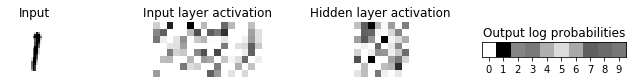

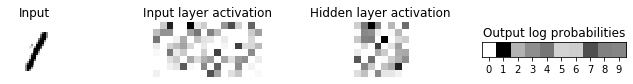

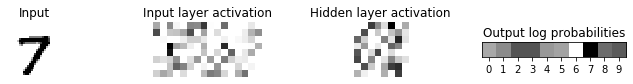

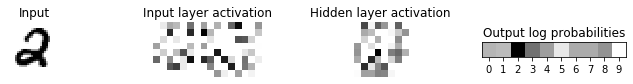

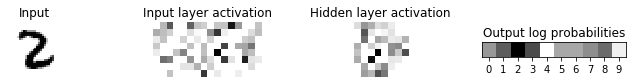

In [70]:
examples = (0, 4, 21, 14, 16)

for j in examples :
    x  = images[j]
    h1 = model.input_layer(x.view(-1).unsqueeze(0)) # .view(8, -1).detach()
    h2 = model.hidden1_layer(h1)
    y  = model.hidden2_layer(h2)

    vis = [
        ('Input', x.squeeze()),
        ('Input layer activation', h1.view(8, -1).detach()),
        ('Hidden layer activation', h2.view(8, -1).detach()),
        ('Output log probabilities', y.detach())
    ]

    figure = plt.figure(figsize = (15, 1))
    for i, (title, img) in enumerate(vis) :
        plt.subplot(1, N_IMAGES, i + 1)
        if i < 3 :
            plt.axis('off')
        else :
            plt.xticks(range(10))
            plt.yticks([])
        plt.title(title)
        plt.imshow(img.numpy(), cmap = 'gray_r')